In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

In [2]:
# Skip date
df1 = pd.read_csv(r'C:\Users\HP\Desktop\BE data\data\testnetflix\combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::1, :])

Dataset 1 shape: (131, 2)
-Dataset examples-
     Cust_Id  Rating
0         1:     NaN
1    1488844     3.0
2     822109     5.0
3     885013     4.0
4      30878     4.0
5     823519     3.0
6     893988     3.0
7     124105     4.0
8    1248029     3.0
9    1842128     4.0
10   2238063     3.0
11   1503895     4.0
12   2207774     5.0
13   2590061     3.0
14      2442     3.0
15    543865     4.0
16   1209119     4.0
17    804919     4.0
18   1086807     3.0
19   1711859     4.0
20    372233     5.0
21    712664     5.0
22   1331154     4.0
23   2632461     5.0
24    712664     1.0
25   1331154     1.0
26   2632461     1.0
27        2:     NaN
28   2059652     4.0
29   1666394     3.0
..       ...     ...
101  2359084     3.0
102   592684     5.0
103  2439493     1.0
104   156319     2.0
105   712664     1.0
106  1331154     1.0
107  2632461     1.0
108       5:     NaN
109  1745265     5.0
110   885013     5.0
111  1997470     5.0
112    30878     1.0
113   840543     4.0
114  24774

In [3]:
# # load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::1, :])

Full dataset shape: (131, 2)
-Dataset examples-
     Cust_Id  Rating
0         1:     NaN
1    1488844     3.0
2     822109     5.0
3     885013     4.0
4      30878     4.0
5     823519     3.0
6     893988     3.0
7     124105     4.0
8    1248029     3.0
9    1842128     4.0
10   2238063     3.0
11   1503895     4.0
12   2207774     5.0
13   2590061     3.0
14      2442     3.0
15    543865     4.0
16   1209119     4.0
17    804919     4.0
18   1086807     3.0
19   1711859     4.0
20    372233     5.0
21    712664     5.0
22   1331154     4.0
23   2632461     5.0
24    712664     1.0
25   1331154     1.0
26   2632461     1.0
27        2:     NaN
28   2059652     4.0
29   1666394     3.0
..       ...     ...
101  2359084     3.0
102   592684     5.0
103  2439493     1.0
104   156319     2.0
105   712664     1.0
106  1331154     1.0
107  2632461     1.0
108       5:     NaN
109  1745265     5.0
110   885013     5.0
111  1997470     5.0
112    30878     1.0
113   840543     4.0
114  24

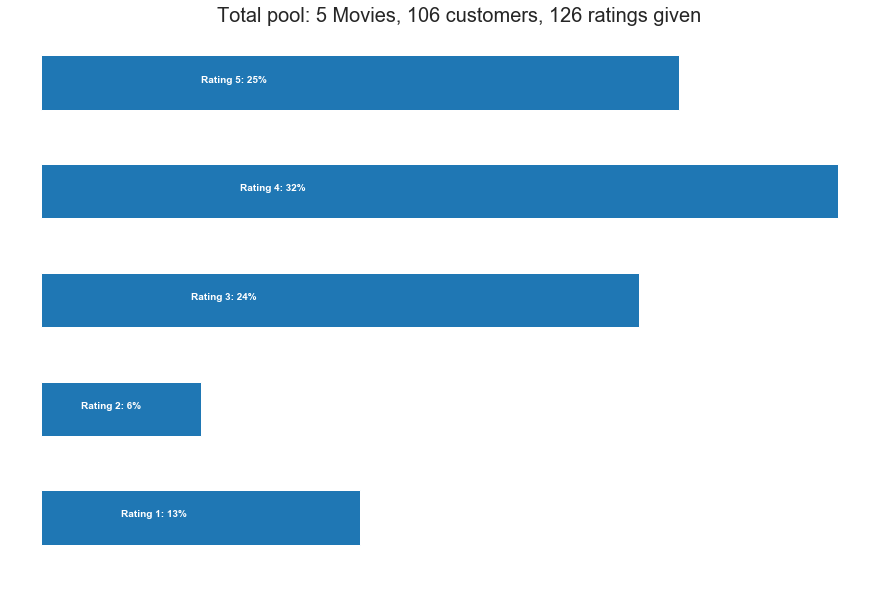

In [4]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [5]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5.]
Length: 126


In [6]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::1, :])

-Dataset examples-
     Cust_Id  Rating  Movie_Id
1    1488844     3.0         1
2     822109     5.0         1
3     885013     4.0         1
4      30878     4.0         1
5     823519     3.0         1
6     893988     3.0         1
7     124105     4.0         1
8    1248029     3.0         1
9    1842128     4.0         1
10   2238063     3.0         1
11   1503895     4.0         1
12   2207774     5.0         1
13   2590061     3.0         1
14      2442     3.0         1
15    543865     4.0         1
16   1209119     4.0         1
17    804919     4.0         1
18   1086807     3.0         1
19   1711859     4.0         1
20    372233     5.0         1
21    712664     5.0         1
22   1331154     4.0         1
23   2632461     5.0         1
24    712664     1.0         1
25   1331154     1.0         1
26   2632461     1.0         1
28   2059652     4.0         2
29   1666394     3.0         2
30   1759415     4.0         2
31   1959936     5.0         2
..       ...     ...

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [7]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.0),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.0),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 22.0
Customer minimum times of review: 1.0


In [8]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::1, :])

Original Shape: (126, 3)
After Trim Shape: (126, 3)
-Data Examples-
     Cust_Id  Rating  Movie_Id
1    1488844     3.0         1
2     822109     5.0         1
3     885013     4.0         1
4      30878     4.0         1
5     823519     3.0         1
6     893988     3.0         1
7     124105     4.0         1
8    1248029     3.0         1
9    1842128     4.0         1
10   2238063     3.0         1
11   1503895     4.0         1
12   2207774     5.0         1
13   2590061     3.0         1
14      2442     3.0         1
15    543865     4.0         1
16   1209119     4.0         1
17    804919     4.0         1
18   1086807     3.0         1
19   1711859     4.0         1
20    372233     5.0         1
21    712664     5.0         1
22   1331154     4.0         1
23   2632461     5.0         1
24    712664     1.0         1
25   1331154     1.0         1
26   2632461     1.0         1
28   2059652     4.0         2
29   1666394     3.0         2
30   1759415     4.0         2
31

In [9]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(106, 5)


In [10]:
df_title = pd.read_csv(r'C:\Users\HP\Desktop\BE data\data\testnetflix\movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

          Year                          Name
Movie_Id                                    
1         2003               Dinosaur Planet
2         2004    Isle of Man TT 2004 Review
3         1997                     Character
4         1994  Paula Abdul's Get Up & Dance
5         2004      The Rise and Fall of ECW
6         1998                       Tin Cup


In [11]:
print(df_p)

Movie_Id    1    2    3    4    5
Cust_Id                          
2442      3.0  NaN  NaN  NaN  NaN
17063     NaN  NaN  NaN  NaN  5.0
30878     4.0  NaN  NaN  NaN  1.0
44937     NaN  NaN  5.0  NaN  NaN
65932     NaN  3.0  NaN  NaN  NaN
66414     NaN  NaN  5.0  2.0  NaN
67315     NaN  NaN  4.0  NaN  NaN
115498    NaN  NaN  3.0  NaN  NaN
124105    4.0  NaN  NaN  NaN  NaN
156319    NaN  NaN  NaN  2.0  NaN
240705    NaN  NaN  NaN  NaN  5.0
264160    NaN  NaN  NaN  NaN  5.0
303948    NaN  NaN  NaN  2.0  NaN
372233    5.0  NaN  NaN  NaN  NaN
392722    NaN  4.0  NaN  NaN  NaN
410199    NaN  NaN  NaN  5.0  NaN
439011    NaN  NaN  1.0  NaN  NaN
543865    4.0  NaN  NaN  NaN  NaN
573975    NaN  3.0  NaN  NaN  NaN
589967    NaN  NaN  NaN  NaN  4.0
592684    NaN  NaN  NaN  5.0  NaN
616720    NaN  NaN  4.0  NaN  NaN
624145    NaN  NaN  NaN  NaN  3.0
656399    NaN  NaN  4.0  NaN  NaN
668811    NaN  NaN  NaN  1.0  NaN
699878    NaN  NaN  4.0  3.0  NaN
701730    NaN  NaN  2.0  NaN  NaN
704249    NaN 

In [12]:
def pcorr(movie_title):
    print("For movie ({})".format(movie_title))
    print("-Movie's Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target)

In [13]:
pcorr("Character")

For movie (Character)
-Movie's Pearsons'R correlation - 
          PearsonR                          Name  count      mean
Movie_Id                                                         
3         1.000000                     Character     24  3.708333
2         0.944911    Isle of Man TT 2004 Review     27  3.703704
1         0.500000               Dinosaur Planet     26  3.538462
5         0.500000      The Rise and Fall of ECW     22  3.954545
4         0.158777  Paula Abdul's Get Up & Dance     27  2.740741
